In [10]:
from intuitlib.client import AuthClient
from quickbooks import QuickBooks
from quickbooks.objects.account import Account
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar

In [11]:
def proc_rows(rows, category = "", level=0):
    row_list = []
    for row in rows:
        if "Header" in row:
            header_col = row['Header']['ColData'][0]['value']
            if category == "":
                current_category = header_col
            else:
                current_category = f"{category}:{header_col}"
            row_list.extend(proc_rows(row['Rows']['Row'], category = current_category, level = level+1))
        else:
            col_data = row['ColData']
            if len(col_data)==len(cols):
                cur_row = {cols[i]:col_data[i]['value'] for i in range(len(cols))}
                cur_row.update({"category":category})
                cur_row.update({"category_level":level})
                row_list.append(cur_row)
    return row_list

In [12]:
auth_client = AuthClient(
        client_id='ABVlDV6VbSq3SyfN6ShES7gauQ8LExHxnhuoDVsKaEOe3GmBrT',
        client_secret='zqQX950hO9CICCreDvfAvk3mE7tuJJKrGyyrRxEU',
        access_token='eyJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwiYWxnIjoiZGlyIn0..bR7NzCZlHM60AAK4SUaAnA.N8bxscVX6zGKhSJUPz2Jx52BeHbRKpnJEgeVzyg3nQ1sX_xviNhoUeC04RD-8TwOgfMqkH4OFI1t3uTSGJvvxG_F5EWHIu0ZG00K6SzizFErJiyS16ecfHXoLuyH8903LgMsxdhGMm-C8n78JE6a8U8-ooaqS_21JWYTpEcGwLUrfocRy19rrIDlawGsJrTe_oXaarTvMXYcOm3QeRGavnatSpIScyLS7z_Lzy8sMyteCn_UlGnMiKKxWpEOIUQWs93USU2tp2mUpM_avZWbaxwM572_3BjuU19dwCYkdYbsYjaWGLGC_lFg83MG5lXihXOk7neHl06ikGzw7dQbk8RfqXRzNwYxyJTlrkN2t2qQdgE1kj8b7DbyuT6LwDNdeyn2MisW4RbgWrMLOKsJx6X9zrexrY_bgEd-NmhsojMdQEoL8_qtJ_Vn46qw91q8g6vPu94TF6u9LsDeDMuHvZVkcPdPThYZaCW7HvoEjqqPs5Zc0PAirt_4r02VNkv8yraHxFA2JblWS5-8ReZc8ZdDKLhpmvrMtVuwOE7Ve4e5AoxYuy7Y3EB3dF34GzMAboLl4dqeYGh40DO8wuejelKubrMqBrWjN4R6u84FDoLCTgt_LVqmnuh7M55m9r-qVoQdiCPQtqpjy0vRONjpWuf3XmG4raMRwpa4b_3FGuU6XjIeFtT_wYm6t_BhhYV4JWApTS4x38_xPV2Uo0svrH3iGSwBy8YZXjremmHROYM.fkDtRqJ9o3aCb1Kd4RszLw',
        environment='production',
        redirect_uri='https://developer.intuit.com/v2/OAuth2Playground/RedirectUrl',
    )

In [13]:
client = QuickBooks(
        auth_client=auth_client,
        refresh_token='AB11697859178JJW61foSdFXCOGSpfRv9II8tIh2or0BDlw6dq',
        company_id='514655250',
    )

In [14]:
# Date information
year = 2023
month = 6 # month number (i.e. 4 for April)
days = calendar.monthrange(year,month)[1]
month_name = calendar.month_name[month]

In [15]:
days = calendar.monthrange(year,month)[1]
month_name = calendar.month_name[month]
print(f"Grabbing report details for {month_name}")
json_resp = client.get_report("ProfitAndLossDetail", {"start_date":f"{year}-{month}-01", "end_date":f"{year}-{month}-{days}"})
cols = [i["ColTitle"] for i in json_resp['Columns']['Column']]
report_info = json_resp['Header']
row_list = proc_rows(json_resp["Rows"]["Row"][0]['Rows']['Row'])

Grabbing report details for June


In [16]:
# data manipulation
qbdf = pd.DataFrame(row_list)
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)

budget_map = "../resources/qb_to_budget_map.csv"
budgetdf = pd.read_csv(budget_map)
budget_items = budgetdf['QB_Item'].unique()

expense_types = ["Check","Expense"]
expenses = qbdf.loc[qbdf['Transaction Type'].astype(str).isin(expense_types)]
income = qbdf.loc[qbdf['Transaction Type'] == 'Deposit']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [17]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum"}).reset_index()
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [18]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

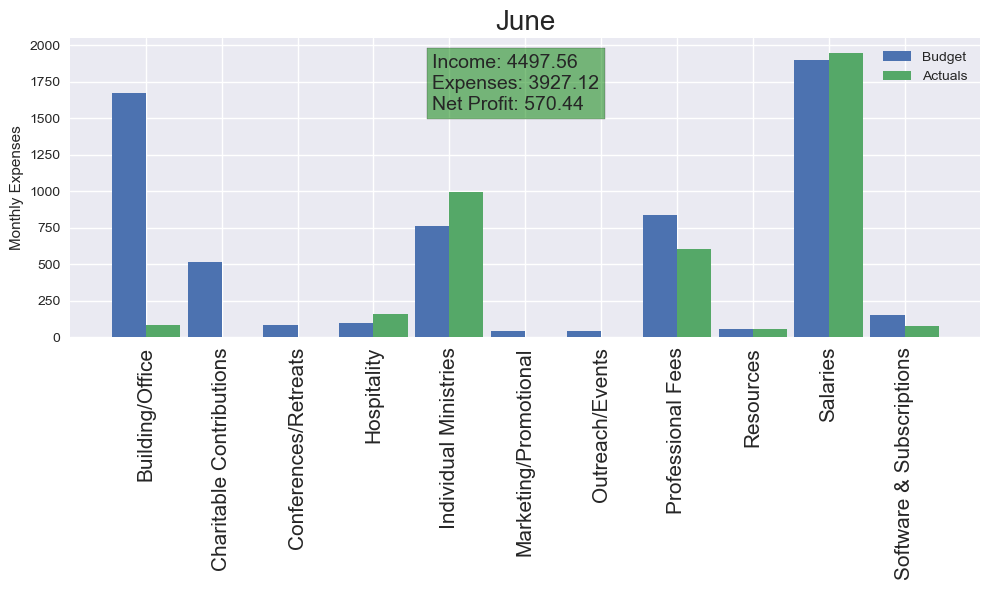

In [19]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [25]:
all_totals[~all_totals['item'].isin(['Lead Pastor','Associate Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Date','item','Amount']]

KeyError: "['Date'] not in index"

In [26]:
all_totals.columns

Index(['Category', 'Subcategory', 'Item', 'QB_Item', 'Budget', 'item',
       'Amount'],
      dtype='object')

In [21]:
all_totals.sort_values("Amount", ascending=False)

,Category,Subcategory,Item,QB_Item,Budget,item,Amount
0,Salaries,Salaries,Lead Pastor,Lead Pastor,1300.00,Lead Pastor,1200.00
1,Salaries,Salaries,Associate Pastor,Associate Pastor,600.00,Associate Pastor,750.00
30,Ministry,Individual Ministries,Honorarium/Blessing,Honorarium/Blessing,250.00,Honorarium/Blessing,500.00
22,Ministry,Individual Ministries,Pastoral Expense,Pastoral Expenses,83.00,Pastoral Expenses,350.45
13,Facilities,Professional Fees,Utilities,Utilities,462.50,Utilities,302.72
16,Facilities,Professional Fees,Lawn/Snow Service,Lawn/Snow,125.00,Lawn/Snow,300.00
20,Facilities,Hospitality,"Food for Events, Sunday Morning",Food for Events/Sunday Morning,42.00,Food for Events/Sunday Morning,158.26
27,Ministry,Individual Ministries,Student Ministry,Student Ministry,42.00,Student Ministry,106.73
3,Facilities,Building/Office,Office Supplies,Office Supplies,42.00,Office Supplies,84.43
21,Facilities,Software & Subscriptions,Software & Subscriptions,Software and Subscriptions,156.00,Software and Subscriptions,77.23


In [23]:
expenses.sort_values("Amount", ascending=False)

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item
27,2023-06-06,Expense,,Code 3 Lawn Rescue,"Visa Check FP *City Quake 203-5 DebitCard, Wi...",1002 ENT Checking (Keystone),500.00,500.00,Expenses:Ministry:Individual Ministries:Honora...,4,Honorarium/Blessing
20,2023-06-28,Expense,,Colo,"Colo Spgs Utilit : PAYMENT : ACH, Withdrawa...",ENT Savings (Keystone),302.72,302.72,Expenses:Facilities:Government/Professional Fe...,4,Utilities
42,2023-06-25,Expense,,,Withdrawal Home Banking Transfer InternetBanki...,1002 ENT Checking (Keystone),300.00,1200.00,Expenses:Salaries:Lead Pastor,3,Lead Pastor
41,2023-06-18,Expense,,David and Catherine Reyes,Withdrawal Home Banking Transfer InternetBanki...,1002 ENT Checking (Keystone),300.00,900.00,Expenses:Salaries:Lead Pastor,3,Lead Pastor
40,2023-06-11,Expense,,,Withdrawal Home Banking Transfer InternetBanki...,1002 ENT Checking (Keystone),300.00,600.00,Expenses:Salaries:Lead Pastor,3,Lead Pastor
39,2023-06-04,Expense,,David and Catherine Reyes,Withdrawal Home Banking Transfer InternetBanki...,1002 ENT Checking (Keystone),300.00,300.00,Expenses:Salaries:Lead Pastor,3,Lead Pastor
28,2023-06-07,Expense,,Amazon,Chair covers,1002 ENT Checking (Keystone),287.97,287.97,Expenses:Ministry:Individual Ministries:Pastor...,4,Pastoral Expenses
38,2023-06-29,Check,367,Joel Longberry,"Check #367 Withdrawal Draft, Withdrawal, Proce...",1002 ENT Checking (Keystone),150.00,750.00,Expenses:Salaries:Associate Pastor,3,Associate Pastor
37,2023-06-21,Check,366,Joel Longberry,"Check #366 Withdrawal Draft, Withdrawal, Proce...",1002 ENT Checking (Keystone),150.00,600.00,Expenses:Salaries:Associate Pastor,3,Associate Pastor
36,2023-06-14,Check,365,,"Check #365 Withdrawal Draft, Withdrawal, Proce...",1002 ENT Checking (Keystone),150.00,450.00,Expenses:Salaries:Associate Pastor,3,Associate Pastor
